In [1]:
import numpy as np
def generate_cont_timeseries(dim=1, length=2000, num_changepoints=100):
    """
    Generate continuous valued time series with changepoints
    """
    changepoint_indices = np.random.choice(range(0, length-1), num_changepoints)

In [2]:
np.diag([1,1,1])

array([[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1]])

In [37]:
def generate_four_changepoints(dim=3, length=5000, means=[5,5,7,8,10,9], covs = [5,5,5,5,5,5]):
    cov_matrix = np.diag(np.repeat(5,dim))
    start = 0
    changepoint_intervals = int(np.floor(length / len(means)))
    time_series = []
    for i in range(len(means)):
        mean_vec = np.repeat(means[i],dim)
        cov_matrix = np.diag(np.repeat(covs[i], dim))
        time_series.extend(np.random.multivariate_normal(mean_vec,cov_matrix, changepoint_intervals))
    return time_series    

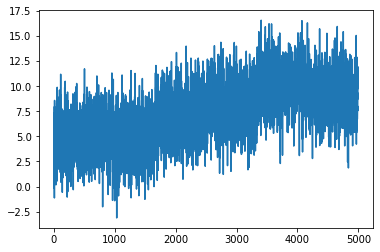

In [38]:
import matplotlib.pyplot as plt

ts = generate_four_changepoints(dim=1)
plt.plot(ts)

In [39]:
train = ts[:2000]
test = ts[2000:]
window = 20

X_train = np.asarray([train[i:i + window] for i in range(len(train) - window-1)])
Y_train = np.asarray([train[i:i + window] for i in range(1, len(train) - window)])
X_test = np.asarray([test[i:i + window] for i in range(len(test) - window-1)])
Y_test = np.asarray([test[i:i + window] for i in range(len(test) - window)])

## VRNN Cell

In [6]:
import tensorflow as tf
import numpy as np
# Implementing Variational RNN's and variations by subclassing Keras RNN-type Cells

class VRNNCell(tf.keras.layers.GRUCell):
    def __init__(self, units, output_dim, **kwargs):
        super(VRNNCell, self).__init__(units, **kwargs)
        self.output_dim = output_dim
    

    def build(self, input_shape):
        # Taking most of the standard weight initiaalizations from the base GRU class
        super().build((input_shape[0], input_shape[1] + self.units))
        
        self.input_kernel = self.add_weight(shape=(input_shape[-1], input_shape[-1]), name="layer", initializer='truncated_normal')
        
        self.prior_kernel = self.add_weight(shape=(self.units, self.units),name="layer", initializer='truncated_normal')
        
        self.pos_kernel = self.add_weight(shape=(input_shape[-1] + self.units,input_shape[-1] + self.units), name="layer", initializer='truncated_normal')
        
        self.encoder_mu_kernel = self.add_weight(shape=(input_shape[-1] + self.units, self.units), name="layer", initializer='truncated_normal')
        
        self.encoder_logvar_kernel = self.add_weight(shape=(input_shape[-1] + self.units, self.units), name="layer", initializer='truncated_normal')
        
        self.prior_mu_kernel = self.add_weight(shape=(self.units, self.units), name="layer", initializer='truncated_normal')
        
        self.prior_logvar_kernel = self.add_weight(shape=(self.units, self.units), name="layer", initializer='truncated_normal')  
        
        self.z_kernel = self.add_weight(shape=(self.units, self.units), name="layer", initializer='truncated_normal')
        
        self.output_kernel = self.add_weight(shape=(self.units + self.units, self.output_dim), name="layer", initializer='truncated_normal')


    def sample(self, mu, log_var):
        # Sample from unit Normal
        dims = tf.shape(mu)
        epsilon = tf.random.normal(dims)
        # All element-wise computations
        std = tf.math.exp(0.5 * log_var)
        z = tf.math.multiply(std, epsilon) + mu
        return z
    
    def call(self, inputs, states, training=False):
        # Some formulations:
        # Generation:
        # z_t ~ N(mu_(0, t), sigma_(0,t)), w here [mu_(0,t), sigma(0,t)] = phi_prior(h_(t-1))
        # Update: 
        # h_t = f_theta(h_(t-1), z_t, x_t) *recurrence equation
        # Inference:
        # z_t ~ N(mu_z, sigma_z), where [mu_z, sigma_z] = phi_post(x_t, h_(t-1))
        #
        # Let the base RNN cell handle the rest and add loss
        
        if training:
            x_t = tf.nn.relu(tf.matmul(inputs, self.input_kernel))
            h_prev = states[0]

            prior = tf.matmul(h_prev, self.prior_kernel)
            p_mu = tf.matmul(prior, self.prior_mu_kernel)
            p_logvar = tf.matmul(prior, self.prior_logvar_kernel)
            
            input_state_concat = tf.concat([x_t, h_prev], axis=1)
            
            pos = tf.matmul(input_state_concat, self.pos_kernel)
            q_mu = tf.matmul(pos, self.encoder_mu_kernel)
            q_logvar = tf.matmul(pos, self.encoder_logvar_kernel)
            z_t = self.sample(q_mu, q_logvar)
            phi_z_t = tf.nn.relu(tf.matmul(z_t, self.z_kernel))
            
            inp = tf.concat([x_t, phi_z_t], axis=1)
            _, h_next = super().call(inp, h_prev)
            
            output = tf.nn.relu(tf.matmul(tf.concat([h_prev, phi_z_t], axis=1), self.output_kernel))
            
            all_output = (output, z_t, q_mu, p_mu, q_logvar, p_logvar)
            return all_output, h_next
        
        else:
           
            x_t = tf.nn.relu(tf.matmul(inputs, self.input_kernel))
            h_prev = states[0]

            prior = tf.matmul(h_prev, self.prior_kernel)
            p_mu = tf.matmul(prior, self.prior_mu_kernel)
            p_logvar = tf.matmul(prior, self.prior_logvar_kernel)
            
            input_state_concat = tf.concat([x_t, h_prev], axis=1)
            
            pos = tf.matmul(input_state_concat, self.pos_kernel)
            q_mu = tf.matmul(pos, self.encoder_mu_kernel)
            q_logvar = tf.matmul(pos, self.encoder_logvar_kernel)
            z_t = self.sample(p_mu, p_logvar)
            phi_z_t = tf.nn.relu(tf.matmul(z_t, self.z_kernel))
            
            inp = tf.concat([x_t, phi_z_t], axis=1)
            _, h_next = super().call(inp, h_prev)
            
            output = tf.nn.relu(tf.matmul(tf.concat([h_prev, phi_z_t], axis=1), self.output_kernel))
            
            all_output = (output, z_t, q_mu, p_mu, q_logvar, p_logvar)
            return all_output, h_next
    
   
    def get_config(self):
        return {"units":self.units}

## VRNN

In [32]:
from tensorflow import keras
def kl_gauss(posterior_means, prior_means, posterior_log_var, prior_log_var):   
    kl = prior_log_var - posterior_log_var + (tf.exp(posterior_log_var) + 
                                       tf.square(posterior_means - prior_means)) / tf.exp(prior_log_var) - 1
    kl = 0.5 * tf.reduce_sum(kl, axis=(1,2))
    return kl

class VRNNGRU(tf.keras.Model):
    def __init__(self, feature_space, latent_dim, timesteps, **kwargs):
        super(VRNNGRU, self).__init__(**kwargs)
        vrnn_cell = VRNNCell(latent_dim, feature_space)
        self.latent_dim = latent_dim
        
        vrnn_input = keras.layers.Input(shape=(timesteps, feature_space))
        vrnn_output = keras.layers.RNN(vrnn_cell, return_sequences=True)(vrnn_input)
        self.vrnn = keras.Model(vrnn_input, vrnn_output)
        
        decoder_input = keras.layers.Input(shape=(timesteps, latent_dim))
        output =  keras.layers.TimeDistributed(keras.layers.Dense(feature_space, activation='softmax'))(decoder_input)
        self.decoder =keras.Model(decoder_input, output)
        
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        if isinstance(data, tuple):
            input_data = data[0]
            output_data = data[1]
            
            timesteps = input_data.shape[1]
            num_feats = input_data.shape[2]
        with tf.GradientTape() as tape:
            outputs = self.vrnn(input_data, training=True)
            preds = outputs[0]
#             preds = self.decoder(z)
            
            q_mu = outputs[2]
            p_mu = outputs[3]
            q_log_var = outputs[4]
            p_log_var = outputs[5]
            
            kl_loss = tf.reduce_mean(kl_gauss(q_mu, p_mu, q_log_var, p_log_var))
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(tf.keras.losses.mean_squared_error(output_data, preds), axis=1)
            )
            total_loss = reconstruction_loss + kl_loss 
            
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)       
        return {
            'total_loss': self.total_loss_tracker.result(),
            'loss': self.reconstruction_loss_tracker.result(),
            'kl': self.kl_loss_tracker.result()
        }

    def call(self, inputs):
        outputs = self.vrnn(inputs, training=True)
        return outputs
    
    def generate(self, inputs):
        outputs = self.vrnn(inputs, training=True)
        return outputs
    

In [ ]:
timesteps = X_train.shape[1]
latent_dim = 2
feature_space = X_train.shape[2]
rvae = VRNNGRU(feature_space, latent_dim, timesteps)
rvae.compile(optimizer=keras.optimizers.Adam(lr=0.001))
rvae.fit(X_train, Y_train, batch_size=8, epochs=80)

In [7]:
def np_kl_gauss(posterior_means, prior_means, posterior_log_var, prior_log_var):
    kl = prior_log_var - posterior_log_var + (np.exp(posterior_log_var) + 
                                       np.square(posterior_means - prior_means)) / np.exp(prior_log_var) - 1
    kl = 0.5 * np.sum(kl)
    return kl

In [194]:
outputs, z, q_mu, p_mu, q_logvar, p_logvar = rvae.predict(X_test)

In [195]:
np_kl_gauss(q_mu[0], p_mu[0], q_logvar[0], p_logvar[0])

0.033423781394958496

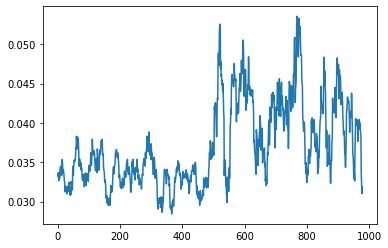

In [196]:
kl_values = []

for i in range(outputs.shape[0]):
    kl_vals = []
    for j in range(outputs.shape[1]):
        kl_vals.append(kl_gauss(q_mu[i][j], p_mu[i][j], q_logvar[i][j], p_logvar[i][j]))
    kl_values.append(kl_vals)

kl_sums = [np.sum(kl) for kl in kl_values]
plt.plot(kl_sums)

In [42]:
from tensorflow.keras import backend as K
import tensorflow_probability as tfp
from tensorflow import keras 
def kl_gauss(posterior_means, prior_means, posterior_log_var, prior_log_var):   
    kl = prior_log_var - posterior_log_var + (tf.exp(posterior_log_var) + 
                                       tf.square(posterior_means - prior_means)) / tf.exp(prior_log_var) - 1
    kl = 0.5 * tf.reduce_sum(kl, axis=[1,2])
    return kl

def wasserstein_loss(y_true, y_pred):
    return tf.reduce_mean(y_true * y_pred)


class kCallback(tf.keras.callbacks.Callback):
    def __init__(self, count, limit):
        self.limit = limit
        self.count = count
    def on_train_batch_end(self, batch, logs={}):
        if self.count == self.limit:
            self.count = 0
        else:
            self.count += 1
        print('k is currently {}'.format(self.count))


class VRNNGRUGAN(tf.keras.Model):
    def __init__(self, feature_space, latent_dim, timesteps, **kwargs):
        super(VRNNGRUGAN, self).__init__(**kwargs)
        vrnn_cell = VRNNCell(latent_dim, feature_space)
        self.feature_space = feature_space
        self.latent_dim = latent_dim
        
        vrnn_input = keras.layers.Input(shape=(timesteps, feature_space))
        vrnn_output = keras.layers.RNN(vrnn_cell, return_sequences=True)(vrnn_input)
        self.vrnn = keras.Model(vrnn_input, vrnn_output)
                
        disc_input = keras.layers.Input(shape=(timesteps, feature_space))
        disc_rnn = keras.layers.GRU(8, recurrent_dropout=0.5, dropout=0.5)(disc_input)
        disc_output = keras.layers.Dense(1, activation='sigmoid')(disc_rnn)
        disc_output = keras.layers.Dropout(0.4)(disc_output)
        disc_model = keras.Model(disc_input, disc_output)
        self.discrim = disc_model
        
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.next_step_loss_tracker = keras.metrics.Mean(
            name="next_step_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.discrim_loss_tracker = keras.metrics.Mean(name="discrim_loss")
        self.discrim_fake_loss_tracker = keras.metrics.Mean(name="discrim_fake_loss")
        self.discrim_real_loss_tracker = keras.metrics.Mean(name="discrim_real_loss")
        self.misled_loss_tracker = keras.metrics.Mean(name="misled_loss")
        
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
            self.discrim_loss_tracker,
            self.discrim_fake_loss_tracker,
            self.discrim_real_loss_tracker,
            self.misled_loss_tracker
        ]
    def compile(self, vae_optimizer, discrim_optimizer):
        super(VRNNGRUGAN, self).compile()
        self.vae_optimizer = vae_optimizer
        self.discrim_optimizer = discrim_optimizer

    def train_step(self, data):
        if isinstance(data, tuple):
            input_data = data[0]
            output_data = data[1]
            
        with tf.GradientTape(persistent=True) as tape:
            outputs = self.vrnn(input_data, training=True)
            preds = outputs[0]
            
            cut_preds = tf.slice(preds, [0,19,0], [-1,-1,-1])
            cut_inputs = tf.slice(input_data, [0,1,0], [-1,-1,-1])
            fake = tf.concat([cut_inputs,cut_preds], axis=1)

            discrim_fake_output = self.discrim(fake)
            discrim_real_output = self.discrim(output_data)
            
            bce_logits = tf.keras.losses.BinaryCrossentropy(from_logits=True)

            discrim_output_loss_fake = tf.reduce_mean(
                tf.keras.losses.binary_crossentropy(tf.zeros_like(discrim_fake_output), discrim_fake_output)
            )
        
            discrim_output_loss_real = tf.reduce_mean(
                tf.keras.losses.binary_crossentropy(tf.ones_like(discrim_real_output), discrim_real_output)
            )
              
            discrim_loss = 0.5 * (discrim_output_loss_fake + discrim_output_loss_real)
        discrim_grads = tape.gradient(discrim_loss, self.discrim.trainable_weights)
        self.discrim_optimizer.apply_gradients(zip(discrim_grads, self.discrim.trainable_weights))
        self.discrim_loss_tracker.update_state(discrim_loss)
        self.discrim_fake_loss_tracker.update_state(discrim_output_loss_fake)
        self.discrim_real_loss_tracker.update_state(discrim_output_loss_real)
        del tape
        
        with tf.GradientTape(persistent=True) as tape:
            outputs = self.vrnn(input_data, training=True)
            preds = outputs[0]
            discrim_fake_output = self.discrim(preds)

            q_mu = outputs[2]
            p_mu = outputs[3]
            q_log_var = outputs[4]
            p_log_var = outputs[5]


            kl_loss = tf.reduce_mean(kl_gauss(q_mu, p_mu, q_log_var, p_log_var))
            bce_logits = tf.keras.losses.BinaryCrossentropy(from_logits=True)

            reconstruction_loss = tf.reduce_mean(
                tf.reduce_mean(tf.keras.losses.mean_squared_error(output_data, preds), axis=1)
            )
            
            mislead_output_discrim_loss = tf.reduce_mean(
                tf.keras.losses.binary_crossentropy(tf.ones_like(discrim_fake_output), discrim_fake_output) 
            )
            
            discrim_loss = tf.reduce_mean(
                tf.keras.losses.binary_crossentropy(tf.zeros_like(discrim_fake_output), discrim_fake_output)
            )
            total_loss =  reconstruction_loss + 0.1 * kl_loss + mislead_output_discrim_loss


        encoder_grads = tape.gradient(total_loss, self.vrnn.trainable_weights)
        encoder_grads,_ = tf.clip_by_global_norm(encoder_grads, 3)
        
        self.vae_optimizer.apply_gradients(zip(encoder_grads, self.vrnn.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.misled_loss_tracker.update_state(mislead_output_discrim_loss)
        del tape
            
        return {
            'total_loss': self.total_loss_tracker.result(),
            'loss': self.reconstruction_loss_tracker.result(),
            'kl': self.kl_loss_tracker.result(),
            'discrim_loss':self.discrim_loss_tracker.result(),
            'discrim_loss_fake':self.discrim_fake_loss_tracker.result(),
            'discrim_loss_real':self.discrim_real_loss_tracker.result(),
            'misled_loss':self.misled_loss_tracker.result(),
        }

    def call(self, inputs):
        outputs = self.vrnn(inputs, training=True)
        return outputs
    
    def generate(self, inputs):
        outputs = self.vrnn(inputs, training=False)
        return outputs
    
    def discrminator_score(self, inputs):
        score = self.discrim(inputs)
        return score
    
    def test_step(self, data):
        inputs = data[0]
        outputs = data[1]
        preds = self(inputs, training=False)
        recon_loss = tf.keras.losses.categorical_crossentropy(outputs, preds)
        return {
            "loss": recon_loss
        }
        

In [43]:
checkpoint_filepath = 'vrnn_gan_cont_checkpoints/vrnngan_cont_best.epoch{epoch:02d}-loss{loss:.2f}'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='loss',
    mode='min',
    save_best_only=True)

timesteps = X_train.shape[1]
latent_dim = 16
feature_space = X_train.shape[2]
rvae = VRNNGRUGAN(feature_space, latent_dim, timesteps)
rvae.compile(keras.optimizers.Adam(lr=0.0001), keras.optimizers.Adam(lr=0.0001))

rvae.fit(X_train, Y_train, batch_size= 8, epochs=100, callbacks=[model_checkpoint_callback] )

Epoch 1/100
248/248 [==============================] - 20s 25ms/step - total_loss: 33.4983 - loss: 33.0922 - kl: 0.0022 - discrim_loss: 0.9236 - discrim_loss_fake: 0.3233 - discrim_loss_real: 1.5880 - misled_loss: 0.7178
Epoch 2/100
248/248 [==============================] - 6s 25ms/step - total_loss: 26.4511 - loss: 29.2942 - kl: 0.2289 - discrim_loss: 0.7977 - discrim_loss_fake: 0.3261 - discrim_loss_real: 1.3275 - misled_loss: 1.0145
Epoch 3/100
248/248 [==============================] - 6s 25ms/step - total_loss: 12.0210 - loss: 13.2670 - kl: 0.5903 - discrim_loss: 0.7369 - discrim_loss_fake: 0.3950 - discrim_loss_real: 1.0932 - misled_loss: 1.1473
Epoch 4/100
248/248 [==============================] - 6s 25ms/step - total_loss: 9.0912 - loss: 8.2523 - kl: 0.0044 - discrim_loss: 0.7088 - discrim_loss_fake: 0.5214 - discrim_loss_real: 0.9068 - misled_loss: 0.9519
Epoch 5/100
248/248 [==============================] - 6s 25ms/step - total_loss: 8.6671 - loss: 7.8313 - kl: 0.0029 - di

248/248 [==============================] - 6s 25ms/step - total_loss: 7.1267 - loss: 6.4003 - kl: 0.0092 - discrim_loss: 0.6085 - discrim_loss_fake: 0.5697 - discrim_loss_real: 0.6458 - misled_loss: 0.8560
Epoch 39/100
248/248 [==============================] - 6s 26ms/step - total_loss: 7.1118 - loss: 6.2000 - kl: 0.0117 - discrim_loss: 0.6052 - discrim_loss_fake: 0.5697 - discrim_loss_real: 0.6474 - misled_loss: 0.8623
Epoch 40/100
248/248 [==============================] - 6s 26ms/step - total_loss: 7.0814 - loss: 6.2185 - kl: 0.0047 - discrim_loss: 0.6052 - discrim_loss_fake: 0.5696 - discrim_loss_real: 0.6424 - misled_loss: 0.8658
Epoch 41/100
248/248 [==============================] - 6s 26ms/step - total_loss: 7.0675 - loss: 6.2575 - kl: 0.0055 - discrim_loss: 0.6044 - discrim_loss_fake: 0.5698 - discrim_loss_real: 0.6398 - misled_loss: 0.8638
Epoch 42/100
248/248 [==============================] - 6s 26ms/step - total_loss: 7.0456 - loss: 6.1283 - kl: 0.0094 - discrim_loss: 0.6

248/248 [==============================] - 6s 25ms/step - total_loss: 6.6516 - loss: 5.7510 - kl: 0.0093 - discrim_loss: 0.5735 - discrim_loss_fake: 0.5319 - discrim_loss_real: 0.6191 - misled_loss: 0.9512
Epoch 76/100
248/248 [==============================] - 6s 25ms/step - total_loss: 6.6422 - loss: 5.6933 - kl: 0.0075 - discrim_loss: 0.5721 - discrim_loss_fake: 0.5302 - discrim_loss_real: 0.6199 - misled_loss: 0.9520
Epoch 77/100
248/248 [==============================] - 6s 25ms/step - total_loss: 6.6508 - loss: 5.6771 - kl: 0.0091 - discrim_loss: 0.5711 - discrim_loss_fake: 0.5274 - discrim_loss_real: 0.6183 - misled_loss: 0.9676
Epoch 78/100
248/248 [==============================] - 6s 25ms/step - total_loss: 6.6325 - loss: 5.7023 - kl: 0.0138 - discrim_loss: 0.5709 - discrim_loss_fake: 0.5294 - discrim_loss_real: 0.6184 - misled_loss: 0.9540
Epoch 79/100
248/248 [==============================] - 6s 25ms/step - total_loss: 6.6251 - loss: 5.6336 - kl: 0.0085 - discrim_loss: 0.5

In [460]:
tf.keras.backend.clear_session()

In [44]:
outputs, z, q_mu, p_mu, q_logvar, p_logvar = rvae.predict(X_test)

(-3.0, 18.0)

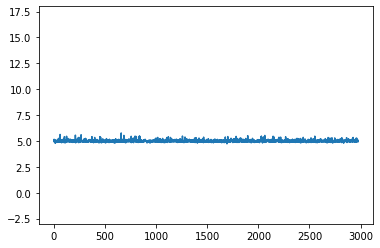

In [45]:
plt.plot(outputs[:,-1,:])
plt.ylim([-3, 18])

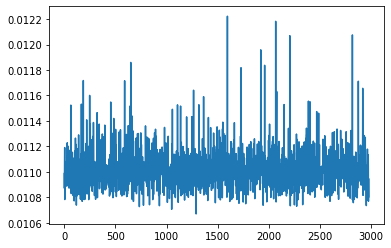

In [46]:
kl_values = []

for i in range(outputs.shape[0]):
    kl_vals = []
    for j in range(outputs.shape[1]):
        kl_vals.append(np_kl_gauss(q_mu[i][j], p_mu[i][j], q_logvar[i][j], p_logvar[i][j]))
    kl_values.append(kl_vals)

kl_sums = [np.sum(kl) for kl in kl_values]
plt.plot(kl_sums)

(-3.0, 18.0)

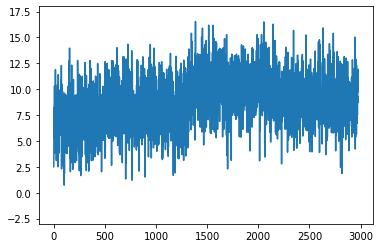

In [47]:
plt.plot(Y_test[:,-1, :])
plt.ylim([-3, 18])

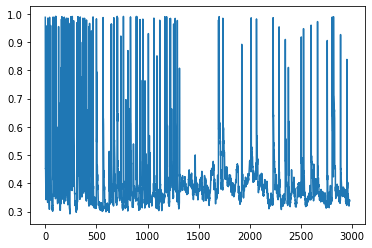

In [48]:
discrim_scores = rvae.discrminator_score(X_test)
plt.plot(discrim_scores)

## LSTM BenchMark

In [640]:
timesteps = X_train.shape[1]
latent_dim = 50
feature_space = X_train.shape[2]

lstm_input = keras.layers.Input(shape=(timesteps, feature_space))
lstm = keras.layers.LSTM(latent_dim, return_sequences=True)(lstm_input)
output = keras.layers.TimeDistributed(keras.layers.Dense(feature_space))(lstm)

lstm_model = keras.Model(lstm_input, output)
lstm_model.compile(keras.optimizers.Adam(lr=0.001), loss='mean_squared_error')
lstm_model.fit(X_train, Y_train, batch_size= 8, epochs=300)

/mnt/c/Users/jchle/Work/Thesis/VAECJ/bash_venv/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/300
123/123 [==============================] - 5s 5ms/step - loss: 14.0532
Epoch 2/300
123/123 [==============================] - 1s 4ms/step - loss: 9.0107
Epoch 3/300
123/123 [==============================] - 1s 4ms/step - loss: 8.5873
Epoch 4/300
123/123 [==============================] - 1s 4ms/step - loss: 8.3358
Epoch 5/300
123/123 [==============================] - 1s 4ms/step - loss: 8.1674
Epoch 6/300
123/123 [==============================] - 1s 4ms/step - loss: 8.0448
Epoch 7/300
123/123 [==============================] - 1s 4ms/step - loss: 7.9515
Epoch 8/300
123/123 [==============================] - 1s 4ms/step - loss: 7.8876
Epoch 9/300
123/123 [==============================] - 1s 4ms/step - loss: 7.8330
Epoch 10/300
123/123 [==============================] - 1s 4ms/step - loss: 7.7949
Epoch 11/300
123/123 [==============================] - 1s 4ms/step - loss: 7.7613
Epoch 12/300
123/123 [==============================] - 1s 4ms/step - loss: 7.7368
Epoch 13/300

123/123 [==============================] - 1s 4ms/step - loss: 2.4633
Epoch 197/300
123/123 [==============================] - 1s 4ms/step - loss: 2.4294
Epoch 198/300
123/123 [==============================] - 1s 4ms/step - loss: 2.4327
Epoch 199/300
123/123 [==============================] - 1s 4ms/step - loss: 2.4259
Epoch 200/300
123/123 [==============================] - 1s 5ms/step - loss: 2.4106
Epoch 201/300
123/123 [==============================] - 1s 5ms/step - loss: 2.4099
Epoch 202/300
123/123 [==============================] - 1s 5ms/step - loss: 2.4169
Epoch 203/300
123/123 [==============================] - 1s 5ms/step - loss: 2.3935
Epoch 204/300
123/123 [==============================] - 1s 5ms/step - loss: 2.3909
Epoch 205/300
123/123 [==============================] - 1s 5ms/step - loss: 2.3880
Epoch 206/300
123/123 [==============================] - 1s 4ms/step - loss: 2.3690
Epoch 207/300
123/123 [==============================] - 1s 4ms/step - loss: 2.3517
Epoch 

In [452]:
lstm_preds = lstm_model.predict(X_test)

(-3.0, 15.0)

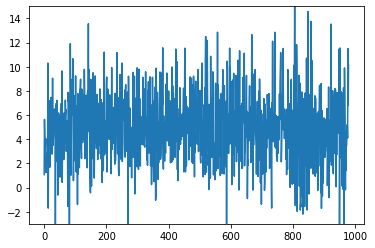

In [453]:
plt.plot(lstm_preds[:,-1,:])
plt.ylim([-3, 15])